In [1]:
import os
import geopandas as  gpd
import pandas as pd
import zipfile 
import sklearn.cluster as cluster
import numpy as np
import pylab as pl
import matplotlib as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/YueCai/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Download NYC zip codes shape file

In [2]:
zip_code_shape = gpd.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
zip_code_shape.head(2)

@id  BLDGpostalCode CTY_FIPS  \
0  http://nyc.pediacities.com/Resource/PostalCode...               0      081   
1  http://nyc.pediacities.com/Resource/PostalCode...               0      081   

   OBJECTID          PO_NAME STATE ST_FIPS    Shape_Area    Shape_Leng  \
0         1  Jackson Heights    NY      36  2.016328e+07  20624.692317   
1         2        Glen Oaks    NY      36  2.260653e+07  23002.816039   

  borough                                           geometry postalCode  
0  Queens  POLYGON ((-73.86942457284175 40.74915687096787...      11372  
1  Queens  POLYGON ((-73.71068374074007 40.75004039450917...      11004

In [3]:
zip_code_shape.columns

Index([           u'@id', u'BLDGpostalCode',       u'CTY_FIPS',
             u'OBJECTID',        u'PO_NAME',          u'STATE',
              u'ST_FIPS',     u'Shape_Area',     u'Shape_Leng',
              u'borough',       u'geometry',     u'postalCode'],
      dtype='object')

In [4]:
# remove columns that won't be used
zip_code_shape.drop([u'@id', u'BLDGpostalCode', u'CTY_FIPS', u'OBJECTID',u'PO_NAME',u'STATE',
                    u'ST_FIPS', u'Shape_Area', u'Shape_Leng'], axis = 1, inplace = True)
zip_code_shape = zip_code_shape.rename(index=int, columns={'postalCode':'zip'})

#zip_code_shape['zip'].dtypes
#Convert 'zip' to a numeric type
zip_code_shape['zip'] = pd.to_numeric(zip_code_shape['zip'], errors = 'coerce')
zip_code_shape.head(2)

borough                                           geometry    zip
0  Queens  POLYGON ((-73.86942457284175 40.74915687096787...  11372
1  Queens  POLYGON ((-73.71068374074007 40.75004039450917...  11004

### Visualize NYC shape via zipcode

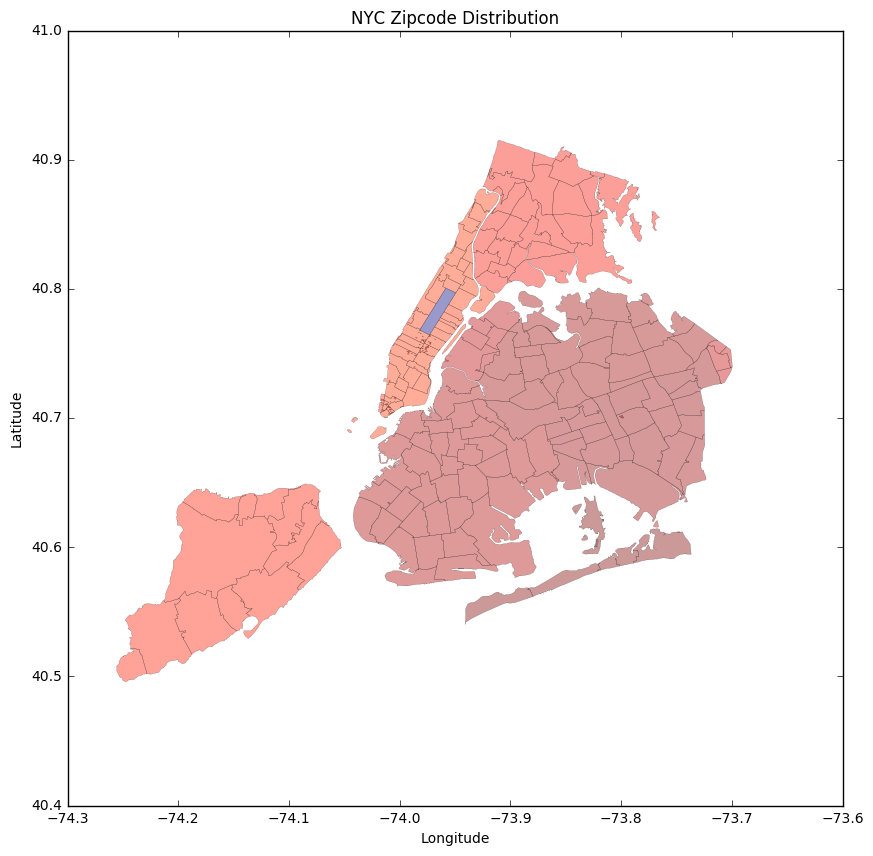

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
zip_code_shape.plot(column='zip',alpha=0.4,linewidth=0.1,ax=ax, legend=False)
plt.title("NYC Zipcode Distribution")

### Download Census Business data

In [6]:
for i in range(1994,2015):
    
    zf = zipfile.ZipFile('zbp'+ str(i)[2:] +'totals.zip')
    data_check = pd.read_csv(zf.open('zbp'+ str(i)[2:] +'totals.zip'.replace('.zip','.txt')))
    
    #from 1998-2002, dataframe cols are all in capitcal case, so I changed them to lowercase
    data_check.columns = map(str.lower, data_check.columns)
    
    #from 2007-2014, cols are increased but not necessarily in this case, so I removed them all...
    #('name','empflag','emp','qp1','ap','emp_nf','qp1_nf','ap_nf','city','stabbr','cty_name')
    #or, I just kept the cols I needed
    data_check1 = data_check[['zip', 'est']]
    
    #merge datasets
    data_check1.rename(columns={'est' : str(i)}, inplace=True)
    zip_code_shape = pd.merge(zip_code_shape, data_check1, on='zip',how='left')

zip_code_shape.head(2)

/Users/YueCai/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2816: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


borough                                           geometry    zip    1994  \
0  Queens  POLYGON ((-73.86942457284175 40.74915687096787...  11372  1229.0   
1  Queens  POLYGON ((-73.71068374074007 40.75004039450917...  11004   194.0   

     1995    1996    1997    1998    1999    2000   ...      2005    2006  \
0  1236.0  1292.0  1309.0  1351.0  1376.0  1409.0   ...    1539.0  1527.0   
1   188.0   176.0   192.0   194.0   186.0   189.0   ...     225.0   226.0   

     2007    2008    2009    2010    2011    2012    2013    2014  
0  1545.0  1538.0  1572.0  1629.0  1647.0  1724.0  1759.0  1768.0  
1   238.0   227.0   233.0   229.0   222.0   241.0   241.0   250.0  

[2 rows x 24 columns]

In [7]:
#snaity check
zip_code_shape.shape

(262, 24)

In [8]:
len(zip_code_shape['zip'].unique())

247

In [9]:
#drop NaN
zip_new = zip_code_shape.dropna()
zip_new.shape

(243, 24)

### Standardize the CB data 

VIP : This is a time series, we can not normalize it by each columns for that will change the timeseries' behaviour. Time series is a set of data points horizontally connected to each others, if we vertically normalize it, the (horizontal) timeseries just 'dislocated'. To aviod this, we can standardize only the row not cloumn!

In [10]:
#each row is subtracted by its mean and then divided by its own standard deviation
zip_standardized = zip_new.copy()
for i in range(len(zip_standardized)):
    mean = (zip_standardized.iloc[i,3:]).mean()
    std = (zip_standardized.iloc[i,3:]).std()
    zip_standardized.iloc[i,3:] = (zip_standardized.iloc[i,3:] - mean) / std
zip_standardized.head(2)

borough                                           geometry    zip      1994  \
0  Queens  POLYGON ((-73.86942457284175 40.74915687096787...  11372 -1.650515   
1  Queens  POLYGON ((-73.71068374074007 40.75004039450917...  11004 -0.974535   

       1995      1996      1997      1998      1999      2000    ...     \
0 -1.607088 -1.259673 -1.154208 -0.893647 -0.738551 -0.533825    ...      
1 -1.248013 -1.794968 -1.065695 -0.974535 -1.339172 -1.202433    ...      

       2005      2006      2007      2008      2009      2010      2011  \
0  0.272673  0.198227  0.309896  0.266469  0.477400  0.831018  0.942687   
1  0.438432  0.484012  1.030967  0.529592  0.803069  0.620751  0.301694   

       2012      2013      2014  
0  1.420382  1.637516  1.693350  
1  1.167706  1.167706  1.577923  

[2 rows x 24 columns]

In [11]:
print((zip_standardized.iloc[0,3:]).mean()) # should nearly to be 0
print((zip_standardized.iloc[0,3:]).std()) # should nearly to be 1

1.1630907877e-16
1.0


### How many clusters? Hints Form Average Silhouette Score about the number of clusters

In [12]:
timeS = zip_standardized.iloc[:,3:]
timeS_PCA = timeS.copy() # save this for later CPA clustering use
timeS_AGG = timeS.copy() # save this for later AGG clustering use
timeS.head(2)

1994      1995      1996      1997      1998      1999      2000  \
0 -1.650515 -1.607088 -1.259673 -1.154208 -0.893647 -0.738551 -0.533825   
1 -0.974535 -1.248013 -1.794968 -1.065695 -0.974535 -1.339172 -1.202433   

       2001      2002      2003    ...         2005      2006      2007  \
0 -0.540029 -0.198818  0.161004    ...     0.272673  0.198227  0.309896   
1 -0.518739 -0.062943  0.575171    ...     0.438432  0.484012  1.030967   

       2008      2009      2010      2011      2012      2013      2014  
0  0.266469  0.477400  0.831018  0.942687  1.420382  1.637516  1.693350  
1  0.529592  0.803069  0.620751  0.301694  1.167706  1.167706  1.577923  

[2 rows x 21 columns]

In [13]:
X = timeS
range_n_clusters = [2,3,4,5,6,7,8,9]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.572142801776
For n_clusters =3, the average silhouette_score is :0.53935365755
For n_clusters =4, the average silhouette_score is :0.498000842087
For n_clusters =5, the average silhouette_score is :0.26268166522
For n_clusters =6, the average silhouette_score is :0.234871300611
For n_clusters =7, the average silhouette_score is :0.235507256381
For n_clusters =8, the average silhouette_score is :0.238456479108
For n_clusters =9, the average silhouette_score is :0.142361639179


According to the score results, we assume there are 2 , 3  or may 4 clusters, it seemed '2' is the most likely number of clusters

### PCA Clustering , n=2

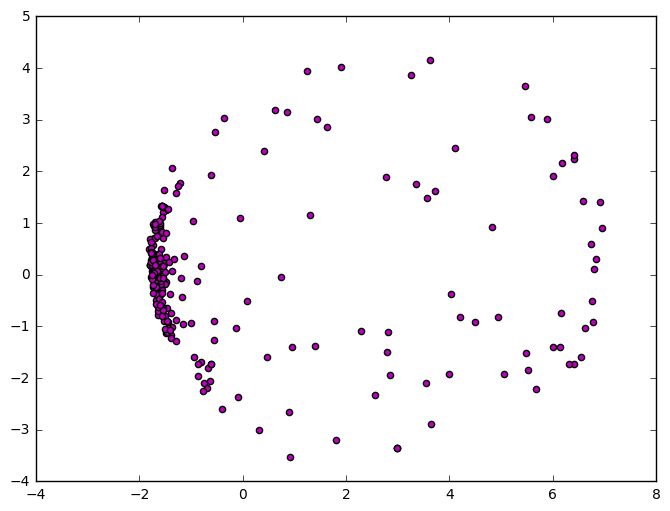

In [14]:
n=2
pca = PCA(n)
Xproj = pca.fit_transform(timeS_PCA)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
plt.scatter(Xproj[:, 0], Xproj[:, 1], c='m')
plt.show()

### Plot PCA clustering center

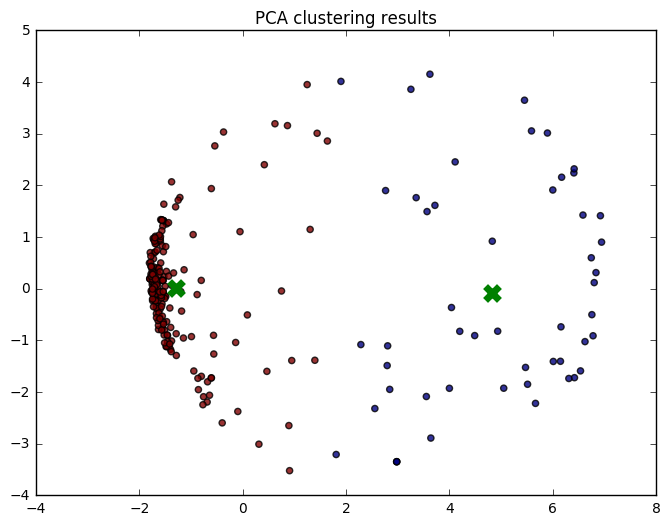

In [15]:
kmeans = KMeans(n_clusters=2).fit(Xproj)
labelskm = kmeans.labels_
centroids = kmeans.cluster_centers_
plt.figure(figsize=(8, 6))
plt.scatter(Xproj[:,0], Xproj[:,1], marker ='o', c = labelskm, alpha=0.8 )
plt.scatter(centroids[:,0],centroids[:,1], marker = "x", c= 'g', s=100, linewidths = 5, zorder = 10)
plt.title("PCA clustering results")
plt.show()

### Hierarchical Clustering

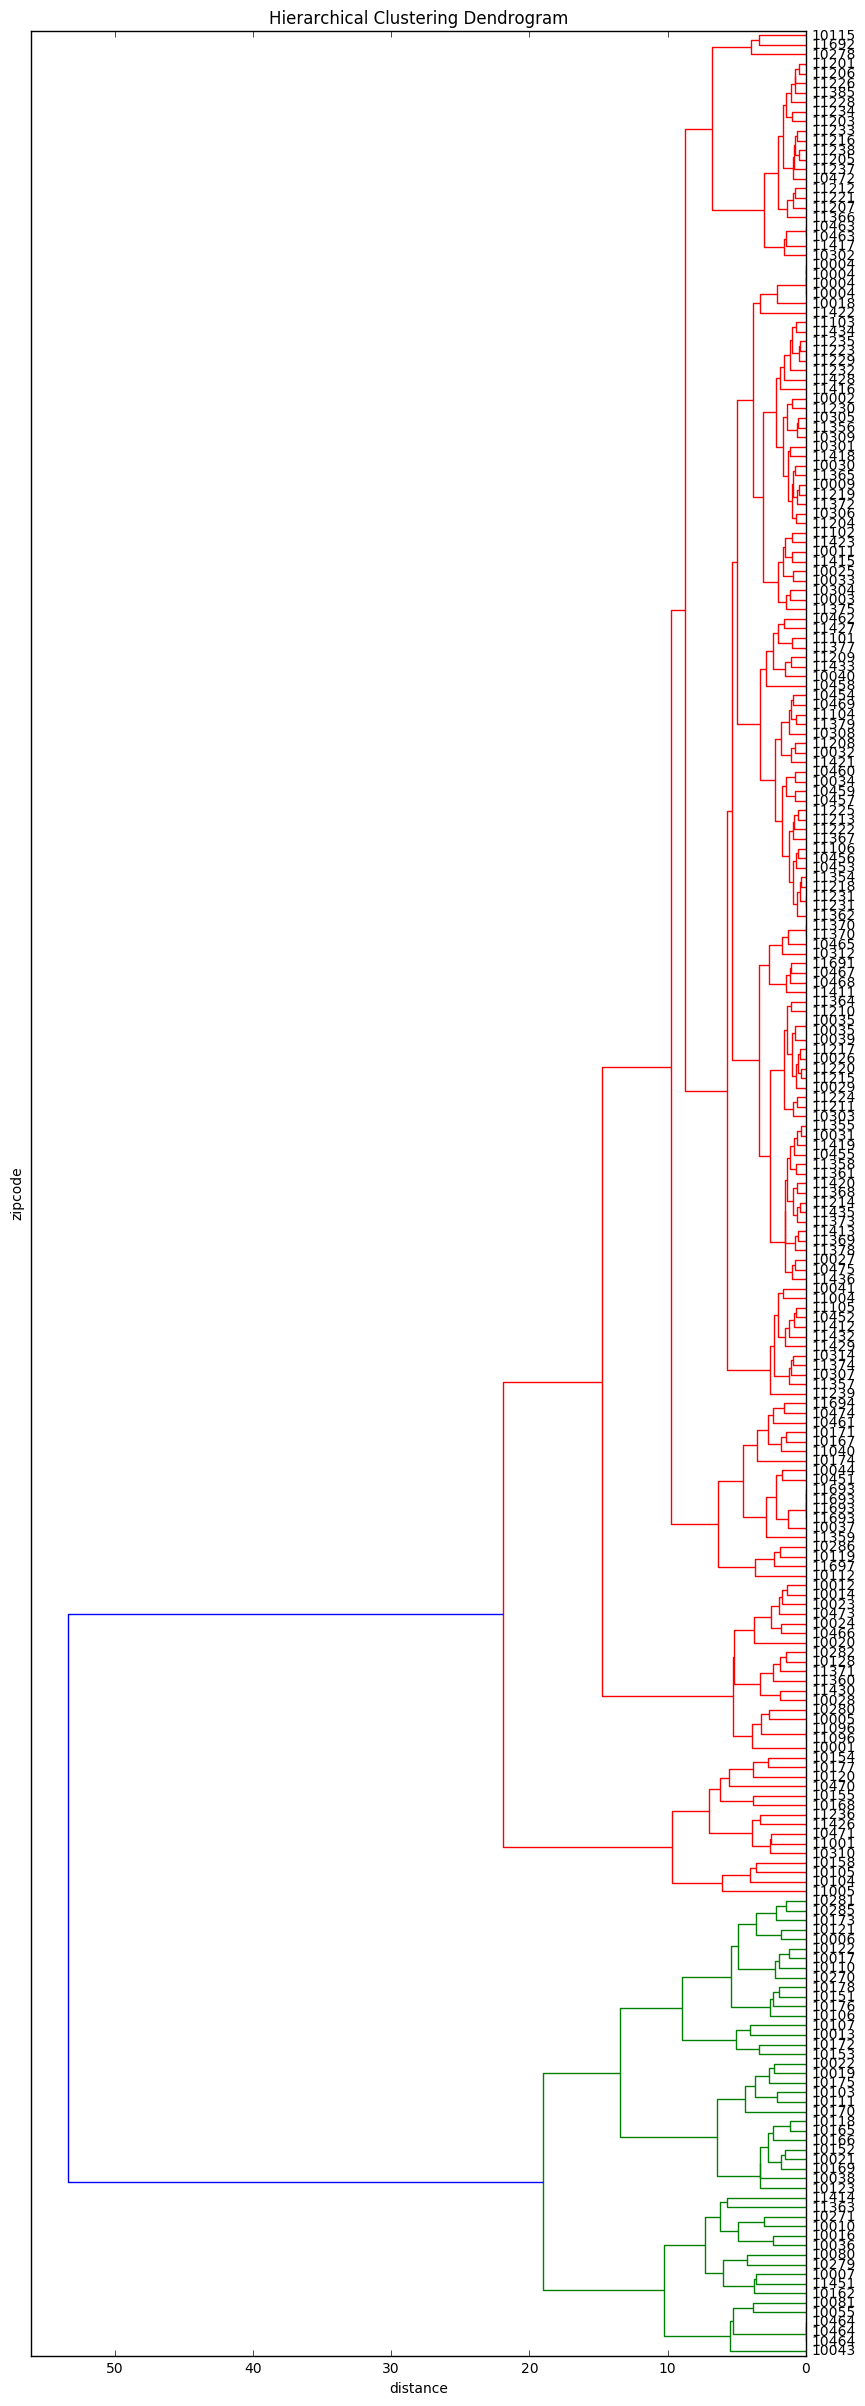

In [16]:
#https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
#http://www.mathworks.com/help/stats/dendrogram.html
#Ward minimizes the sum of squared differences within all clusters
Z = linkage(zip_standardized.iloc[:, 3:24], 'ward')
plt.figure(figsize=(10, 30))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('distance') 
plt.ylabel('zipcode')
dendrogram(
    Z,
    #leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10., # font size for the x axis labels
    orientation='left', # change the rientation of the dendrogra
    labels = zip_standardized['zip'].values
)
plt.show()

It seemed, roughly, there are two clusters by minimizing the sum of squared differences within all clusters

### Create a time serise 

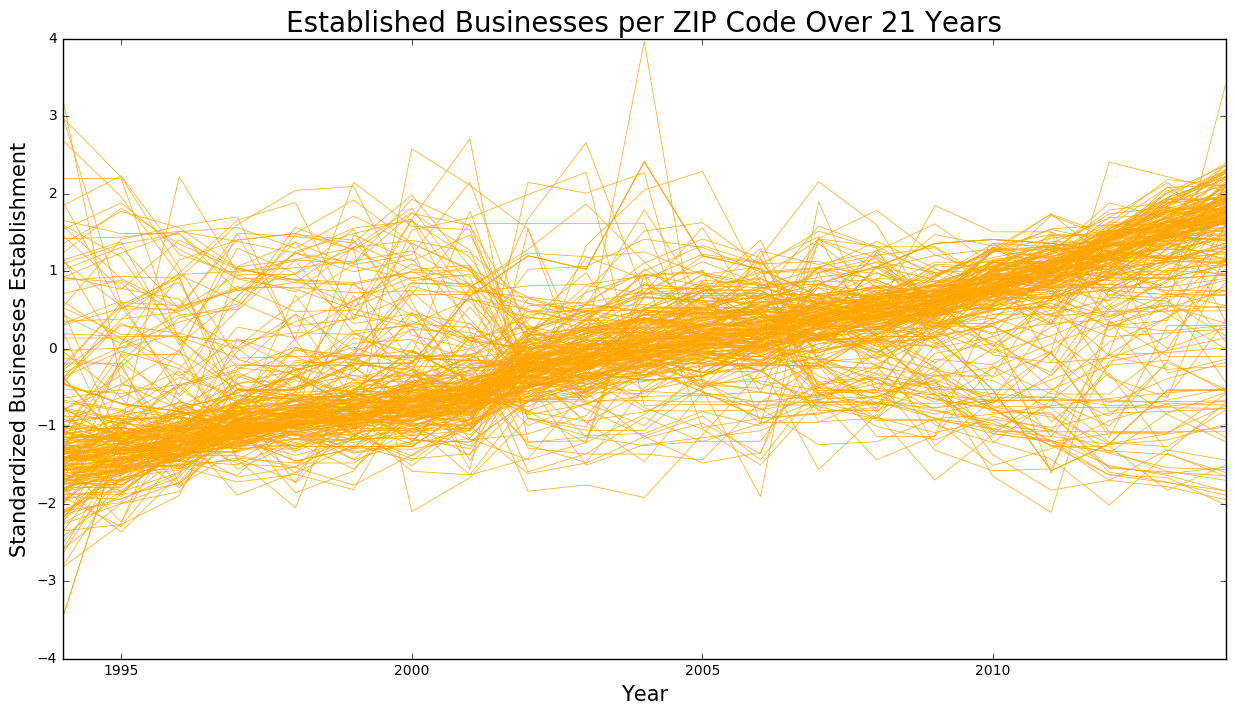

In [17]:
pl.figure(figsize=(15,8))
for i in range(len(timeS)):
    pl.plot(timeS.iloc[i],'-', color='orange', linewidth=0.5)

pl.xlim(1994,2014)
pl.xlabel("Year", fontsize=15)
pl.ylabel("Standardized Businesses Establishment", fontsize=15)
pl.title("Established Businesses per ZIP Code Over 21 Years", fontsize=20)

### K-Means Clustering

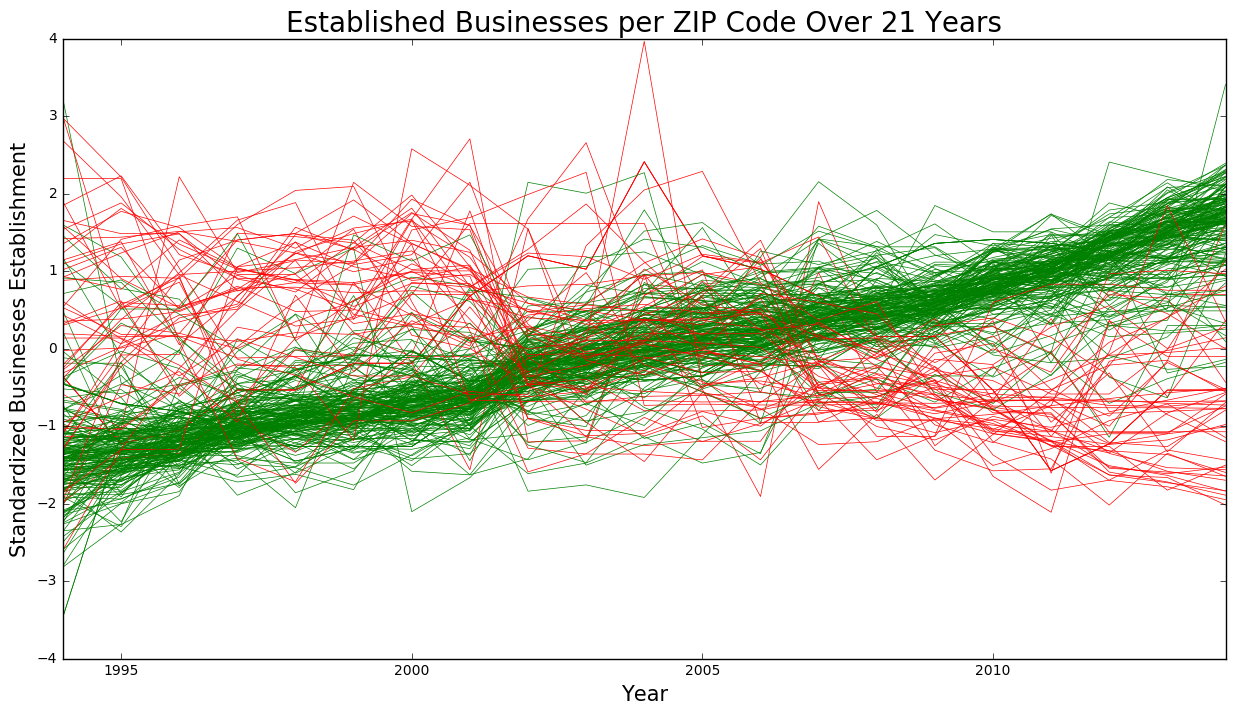

In [18]:
# K mean clustering, n = 2

color = ['red', 'green']
km1=KMeans(n_clusters=2).fit(timeS)
pl.figure(figsize=(15,8))
for i in range(len(timeS)):
    pl.plot(timeS.iloc[i],'-',c=color[km1.labels_[i]], linewidth=0.5)

pl.xlim(1994,2014)
pl.xlabel("Year", fontsize=15)
pl.ylabel("Standardized Businesses Establishment", fontsize=15)
pl.title("Established Businesses per ZIP Code Over 21 Years", fontsize=20)

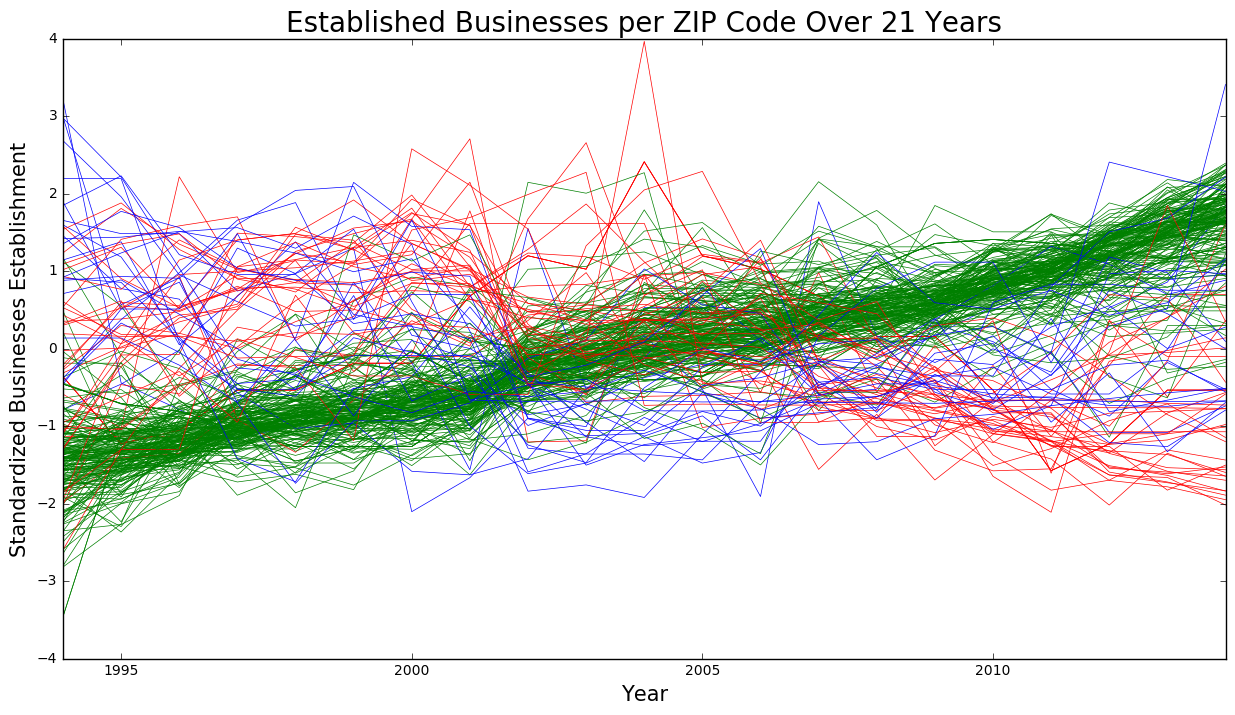

In [19]:
# K mean clustering, n = 3

color = ['red', 'green', 'blue']
km2=KMeans(n_clusters=3).fit(timeS)
pl.figure(figsize=(15,8))
for i in range(len(timeS)):
    pl.plot(timeS.iloc[i],'-',c=color[km2.labels_[i]], linewidth=0.5)

pl.xlim(1994,2014)
pl.xlabel("Year", fontsize=15)
pl.ylabel("Standardized Businesses Establishment", fontsize=15)
pl.title("Established Businesses per ZIP Code Over 21 Years", fontsize=20)

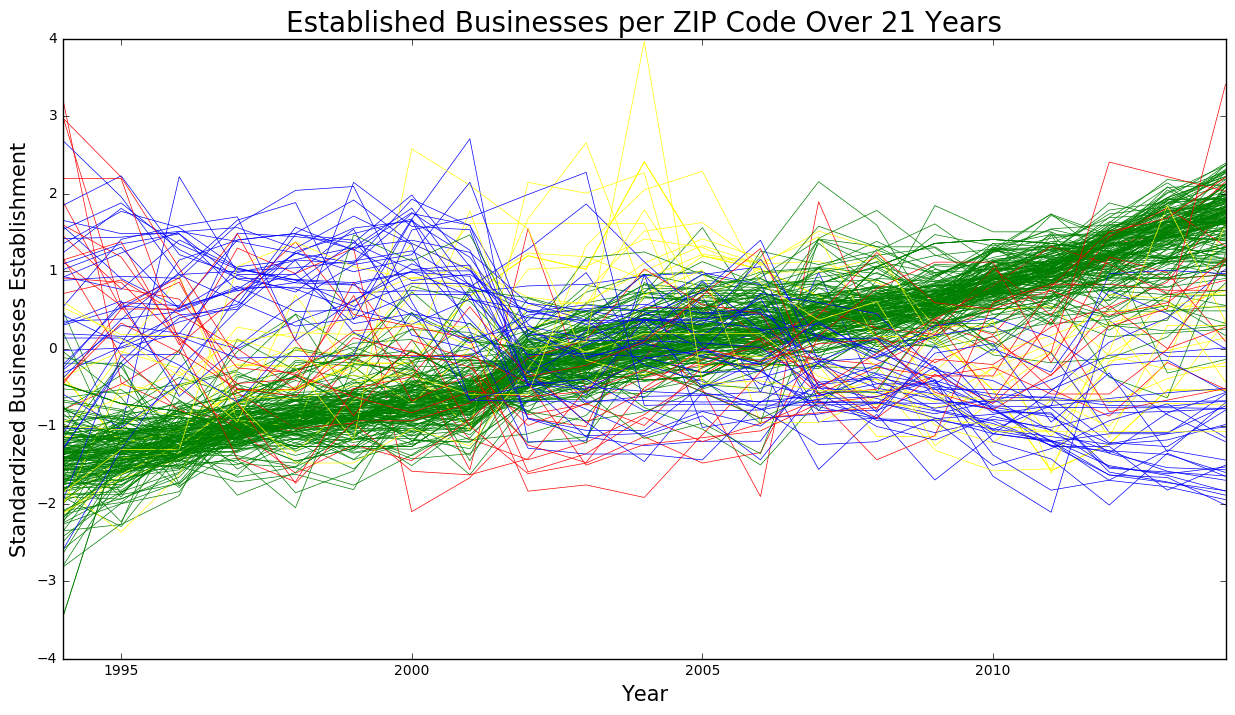

In [20]:
# K mean clustering, n = 4

color = ['red', 'green', 'blue', 'yellow']
km3=KMeans(n_clusters=4).fit(timeS)
pl.figure(figsize=(15,8))
for i in range(len(timeS)):
    pl.plot(timeS.iloc[i],'-',c=color[km3.labels_[i]], linewidth=0.5)

pl.xlim(1994,2014)
pl.xlabel("Year", fontsize=15)
pl.ylabel("Standardized Businesses Establishment", fontsize=15)
pl.title("Established Businesses per ZIP Code Over 21 Years", fontsize=20)

In [21]:
print(km3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


### Plot K-Means clustering center

In [22]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(timeS)
centroids = kmeans.cluster_centers_

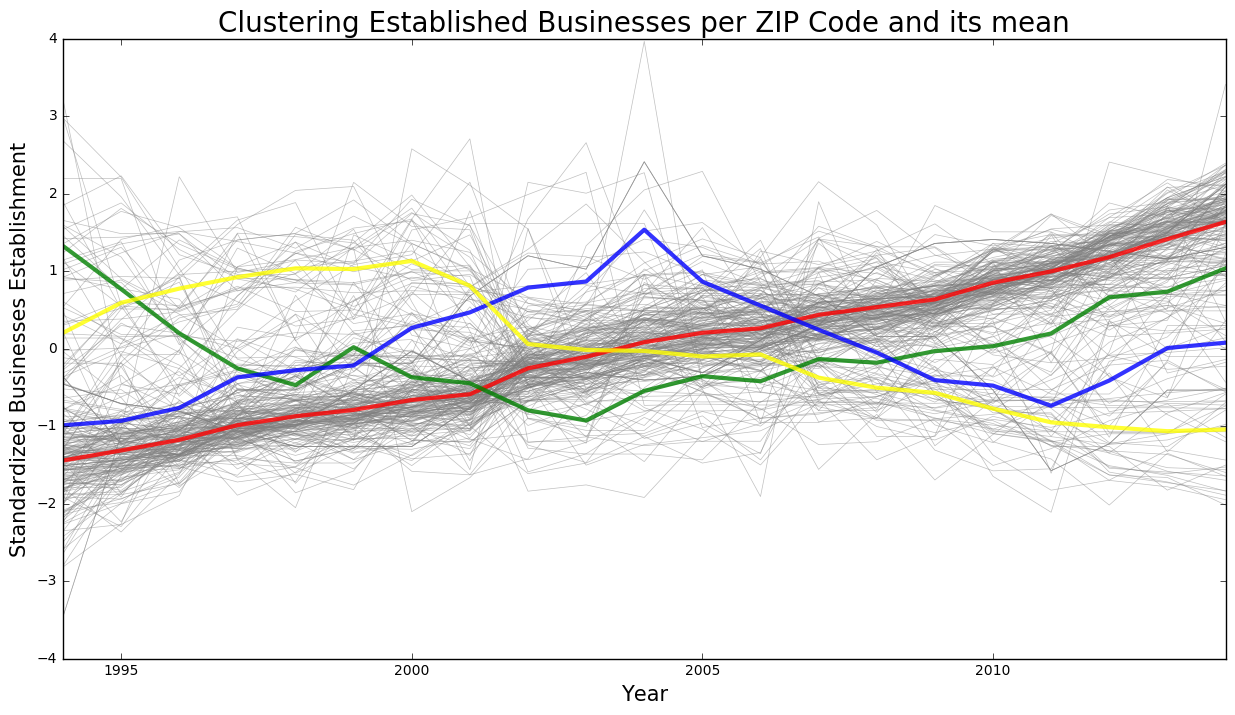

In [23]:
pl.figure(figsize=(15,8))
for i in range(len(timeS)):
    pl.plot(timeS.iloc[i],'-', alpha=0.5, c='gray', linewidth=0.5)
for i in range(len(centroids)):
    pl.plot(range(1994,2015), centroids[i], alpha=0.8, linewidth=3, c=color[i])
pl.xlim(1994,2014) 
pl.xlabel("Year", fontsize=15)
pl.ylabel("Standardized Businesses Establishment", fontsize=15)
pl.title("Clustering Established Businesses per ZIP Code and its mean", fontsize=20)

In [24]:
timeS['labelskm']= km3.labels_

In [25]:
zip_infro = pd.concat([zip_code_shape, timeS], axis=1)
zip_infro.head(2)

borough                                           geometry    zip    1994  \
0  Queens  POLYGON ((-73.86942457284175 40.74915687096787...  11372  1229.0   
1  Queens  POLYGON ((-73.71068374074007 40.75004039450917...  11004   194.0   

     1995    1996    1997    1998    1999    2000    ...         2006  \
0  1236.0  1292.0  1309.0  1351.0  1376.0  1409.0    ...     0.198227   
1   188.0   176.0   192.0   194.0   186.0   189.0    ...     0.484012   

       2007      2008      2009      2010      2011      2012      2013  \
0  0.309896  0.266469  0.477400  0.831018  0.942687  1.420382  1.637516   
1  1.030967  0.529592  0.803069  0.620751  0.301694  1.167706  1.167706   

       2014  labelskm  
0  1.693350       1.0  
1  1.577923       1.0  

[2 rows x 46 columns]

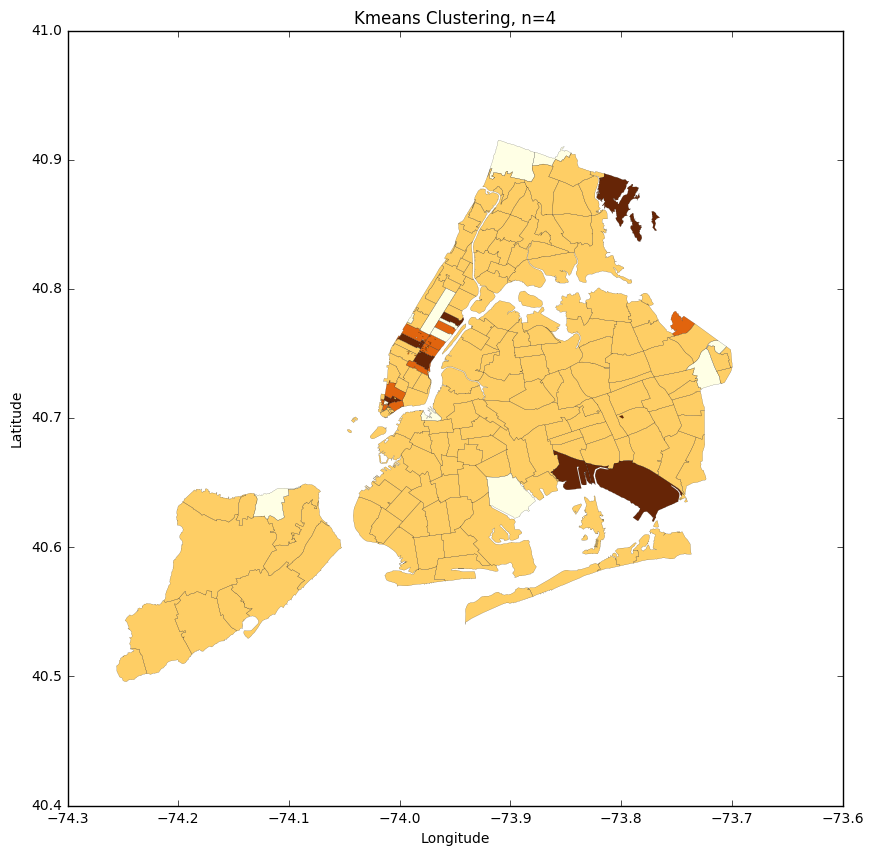

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
zip_infro.plot(column='labelskm',cmap='YlOrBr',alpha=1,linewidth=0.1,ax=ax,label= True)
plt.title("Kmeans Clustering, n=4")

### Use another clustering algorithm

In [27]:
agc = AgglomerativeClustering(n_clusters=4, compute_full_tree=True).fit(timeS_AGG)
labelsag = agc.labels_

In [28]:
timeS['labelsag']= labelsag

In [29]:
zip_infro1 = pd.concat([zip_code_shape, timeS], axis=1)
zip_infro1.head(2)

borough                                           geometry    zip    1994  \
0  Queens  POLYGON ((-73.86942457284175 40.74915687096787...  11372  1229.0   
1  Queens  POLYGON ((-73.71068374074007 40.75004039450917...  11004   194.0   

     1995    1996    1997    1998    1999    2000    ...         2007  \
0  1236.0  1292.0  1309.0  1351.0  1376.0  1409.0    ...     0.309896   
1   188.0   176.0   192.0   194.0   186.0   189.0    ...     1.030967   

       2008      2009      2010      2011      2012      2013      2014  \
0  0.266469  0.477400  0.831018  0.942687  1.420382  1.637516  1.693350   
1  0.529592  0.803069  0.620751  0.301694  1.167706  1.167706  1.577923   

   labelskm  labelsag  
0       1.0       0.0  
1       1.0       0.0  

[2 rows x 47 columns]

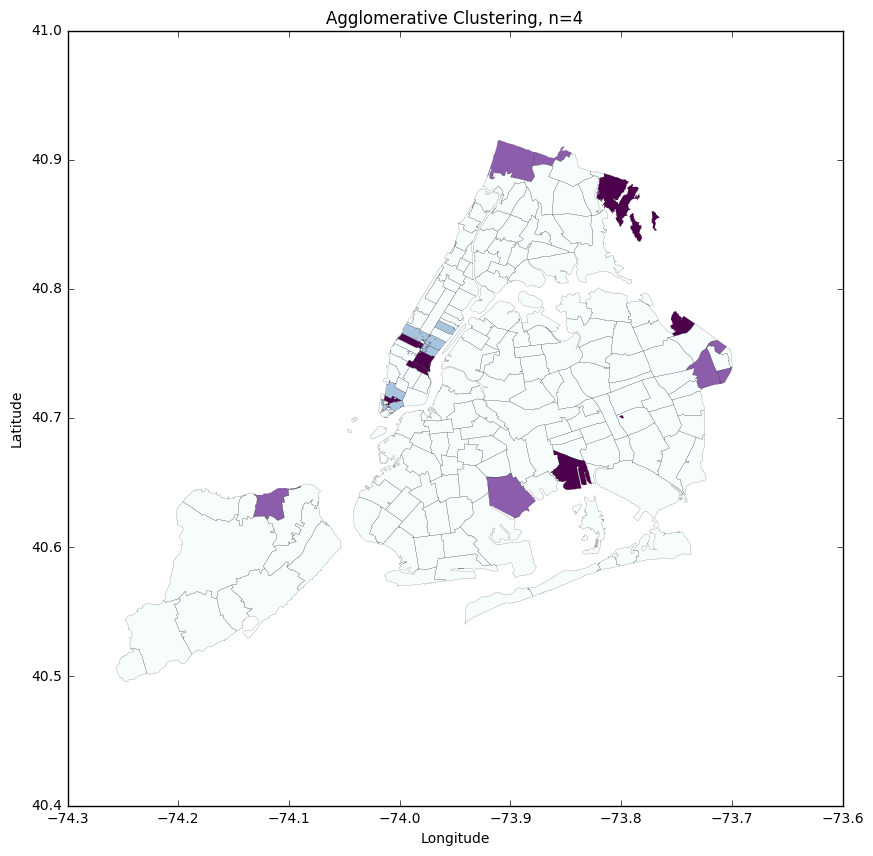

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
zip_infro1.plot(column='labelsag',cmap='BuPu',alpha=1,linewidth=0.1,ax=ax,label= True)
plt.title("Agglomerative Clustering, n=4")

### Compare the results of kmeans clustering and agglomerative clustering

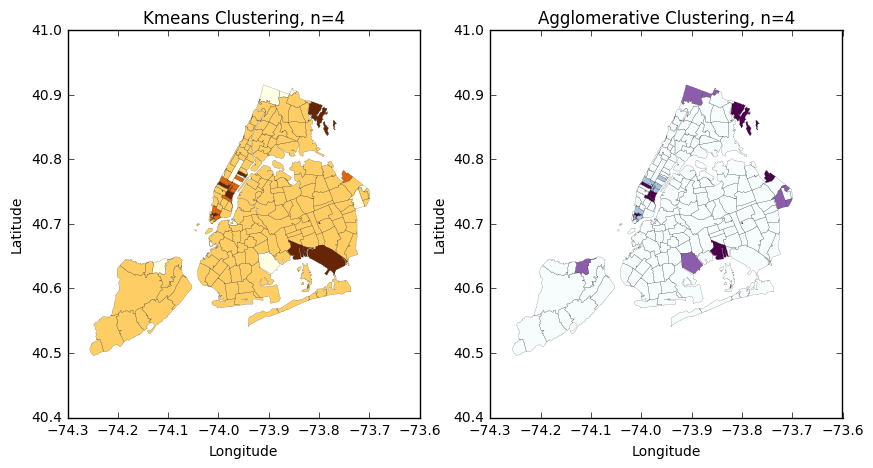

In [31]:
fig,ax = plt.subplots(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.get_xaxis().set_visible(True)
ax1.get_yaxis().set_visible(True)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

zip_infro.plot(column='labelskm',cmap='YlOrBr',alpha=1,linewidth=0.1,ax=ax1,label= True)
plt.title("Kmeans Clustering, n=4")

ax2 = plt.subplot(122)
ax2.get_xaxis().set_visible(True)
ax2.get_yaxis().set_visible(True)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

zip_infro1.plot(column='labelsag',cmap='BuPu',alpha=1,linewidth=0.1,ax=ax2,label= True)
plt.title("Agglomerative Clustering, n=4")

The figures resemble to each other although they are produced by different algorithms. This might indicate strong affinity among those elements within the same cluster. In other words, in spite of various ways of clustering, the
results are analogous because elements belong to the same cluster always display very similar behaviors.